In [1]:
!pip install diffusers transformers accelerate --upgrade

In [2]:
import pathlib as pl
import json
import torch
import torchvision
import torchvision.transforms.v2 as tv2
import matplotlib.pyplot as plt


In [3]:
!rm -r sample_data
from google.colab import drive
drive.mount('/content/drive')

rm: cannot remove 'sample_data': No such file or directory
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
dataset_path = pl.Path('/content/drive/MyDrive/Datasets/pandaset')
example_scene = "001"

In [5]:
def sort_paths_numerically(paths: list[pl.Path]) -> list[pl.Path]:
  return sorted(paths, key=lambda path: int(path.stem))


def get_scene_dir_path(dataset_path, scene_name):
  return dataset_path / scene_name


def load_json(path):
    with open(path, 'rb') as f:
      return json.load(f)


def get_samples_from_scene_path(scene_path, camera_name):
  cam_path = scene_path / "camera" / camera_name
  imgs_paths = list(sorted(cam_path.glob("*.jpg")))

  intrinsics = load_json(cam_path / "intrinsics.json")
  poses = load_json(cam_path / "poses.json")
  timestamps = load_json(cam_path / "timestamps.json")

  data = {
      "imgs": imgs_paths,
      "poses": poses,
      "timestamps": timestamps,
      "intrinsics": intrinsics
  }

  return data

data = get_samples_from_scene_path(get_scene_dir_path(dataset_path, example_scene), "front_camera")

In [6]:
def read_image_from_sample(data, sample_idx):
  img_path = data["imgs"][sample_idx]
  img = torchvision.io.read_image(str(img_path))
  return img


def process_img_tensor(img, tfs):
  return tfs(img)

In [7]:
transforms = tv2.Compose([
    tv2.Resize((1080//8, 1920//8))
])

ex_img = read_image_from_sample(data, 0)
ex_img_pp = process_img_tensor(ex_img, transforms)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


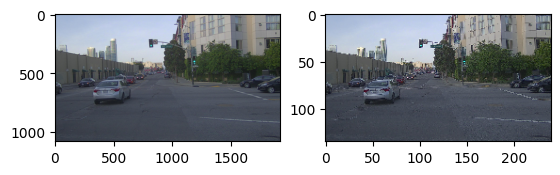

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(ex_img.permute(1, 2, 0))
ax2.imshow(ex_img_pp.permute(1, 2, 0))

In [9]:
from diffusers import AutoPipelineForImage2Image
from diffusers.utils import load_image
import torch

pipe = AutoPipelineForImage2Image.from_pretrained("stabilityai/sdxl-turbo", torch_dtype=torch.float16, variant="fp16")
pipe.to("cuda")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionXLImg2ImgPipeline {
  "_class_name": "StableDiffusionXLImg2ImgPipeline",
  "_diffusers_version": "0.26.3",
  "_name_or_path": "stabilityai/sdxl-turbo",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "requires_aesthetics_score": false,
  "scheduler": [
    "diffusers",
    "EulerAncestralDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [10]:
prompt = ""

torch.cuda.empty_cache()
image = pipe(prompt, image=ex_img, num_inference_steps=1, strength=0.5, guidance_scale=0.0).images[0]
image

0it [00:00, ?it/s]

RuntimeError: cannot reshape tensor of 0 elements into shape [0, -1, 1, 512] because the unspecified dimension size -1 can be any value and is ambiguous

In [ ]:
del image
